In [1]:
import numpy as np
import pandas as pd
from datetime import date, time, datetime
import re
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statistics import mode
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
#lee el archivo separando en lineas.
datos_temp_min = []
with open('195134_BUENOS_AIRES_OBSERVATORIO_temp_min.txt', encoding='iso-8859-1') as fname:
	lineas = fname.readlines()
	for linea in lineas:
		datos_temp_min.append(linea.strip('\n'))

In [3]:
datos_temp_max = []
with open('195134_BUENOS_AIRES_OBSERVATORIO_temp_max.txt', encoding='iso-8859-1') as fname:
	lineas = fname.readlines()
	for linea in lineas:
		datos_temp_max.append(linea.strip('\n'))

In [4]:
def read_txt_temp_min(data,year_i,year_f):
    datos = []
    with open(data, encoding='iso-8859-1') as fname:
	    lineas = fname.readlines()
	    for linea in lineas:
		    datos.append(linea.strip('\n'))
    years = range(year_i,year_f,1) 
    
    fechas = []
    temps_min = []

    #Barremos los anios
    for y in years :
    
        indice = datos.index(f'Año {y} Temperatura Mínima (°C)')
        indice_sig = datos.index(f'Año {y+1} Temperatura Mínima (°C)')
    
    #Barremos los dias
        for d in range(indice+4,indice_sig-2,1):
            d2 = datos[d]
            d2= re.sub(r" ", "",d2).split(";")
            
            dia = int(d2[0])
    # Barremos los meses    
            for m in range(len(d2)-2):               

                try:
                    fecha = date(day=dia, month=m+1, year=y)
                    fechas.append(fecha)                    
                    temp_min = d2[m+1]
                    if (d2[m+1] == 's/d'):
                        #print('no existe')
                        temp_min = float('nan')
                    else:
                        temp_min = float(d2[m+1].replace(',','.'))
                    temps_min.append(temp_min) 
                except ValueError as error_in_date:
                    pass
                

    df = pd.DataFrame()
    df['Fecha']= fechas
    df['temp_min']=temps_min
    df = df.sort_values(by='Fecha')
    df = df.set_index('Fecha')
    return df

In [5]:
def read_txt_temp_max(data,year_i,year_f):
    datos = []
    with open(data, encoding='iso-8859-1') as fname:
	    lineas = fname.readlines()
	    for linea in lineas:
		    datos.append(linea.strip('\n'))
    years = range(year_i,year_f,1) 
    
    fechas = []
    temps_min = []

    #Barremos los anios
    for y in years :
    
        indice = datos.index(f'Año {y} Temperatura Máxima (°C)')
        indice_sig = datos.index(f'Año {y+1} Temperatura Máxima (°C)')
    
    #Barremos los dias
        for d in range(indice+4,indice_sig-2,1):
            d2 = datos[d]
            d2= re.sub(r" ", "",d2).split(";")
            
            dia = int(d2[0])
    # Barremos los meses    
            for m in range(len(d2)-2):               

                try:
                    fecha = date(day=dia, month=m+1, year=y)
                    fechas.append(fecha)                    
                    temp_min = d2[m+1]
                    if (d2[m+1] == 's/d'):
                        #print('no existe')
                        temp_min = float('nan')
                    else:
                        temp_min = float(d2[m+1].replace(',','.'))
                    temps_min.append(temp_min) 
                except ValueError as error_in_date:
                    pass
                

    df = pd.DataFrame()
    df['Fecha']= fechas
    df['temp_max']=temps_min
    df = df.sort_values(by='Fecha')
    df = df.set_index('Fecha')
    return df

In [6]:
df_temp_min = read_txt_temp_min('195134_BUENOS_AIRES_OBSERVATORIO_temp_min.txt',1909,2022)
df_temp_max = read_txt_temp_max('195134_BUENOS_AIRES_OBSERVATORIO_temp_max.txt',1909,2022)

In [7]:
df_temp_min.head(3)

,temp_min
Fecha,
1909-01-01,18.9
1909-01-02,21.3
1909-01-03,19.1


In [8]:
df_temp_max.head(3)

,temp_max
Fecha,
1909-01-01,26.5
1909-01-02,28.9
1909-01-03,29.1


In [9]:
#Se pasa la fecha a formato datetime

df_temp_min.index = pd.to_datetime(df_temp_min.index)
df_temp_max.index = pd.to_datetime(df_temp_max.index)

In [10]:
#Se crea un dataframe para temperatura minima y maxima, agrupado por año y mes con la media de cada mes

df_temp_min_mensual=pd.DataFrame(df_temp_min.groupby(pd.PeriodIndex(df_temp_min.index, freq="M"))['temp_min'].mean())
df_temp_max_mensual=pd.DataFrame(df_temp_max.groupby(pd.PeriodIndex(df_temp_max.index, freq="M"))['temp_max'].mean())

In [11]:
df_temp_min_mensual.head(3)

,temp_min
Fecha,
1909-01,17.422581
1909-02,16.000000
1909-03,13.012903


In [12]:
df_temp_max_mensual.head(3)

,temp_max
Fecha,
1909-01,28.929032
1909-02,26.560714
1909-03,25.329032


In [13]:
#Se verifican nulos en cada uno de los dos datasets

df_temp_min_mensual.isna().value_counts()

temp_min
False       1356
dtype: int64

In [14]:
df_temp_max_mensual.isna().value_counts()

temp_max
False       1355
True           1
dtype: int64

In [15]:
#Como temperatura maxima tiene un nulo, vamos a imputarle un valor

df_temp_max_mensual[df_temp_max_mensual.isnull()['temp_max']==True]

,temp_max
Fecha,
1986-07,NaN


In [16]:
#El valor faltante es la temperatura maxima en julio de 1986, se va a imputar como la media de la temperatura maxima de julio de los 5 años anteriores
mask_temp_max_80s = df_temp_max_mensual.index.year.isin([1980,1981,1982,1983,1984,1985])
df_1980s=df_temp_max_mensual[mask_temp_max_80s]
df_1980s[df_1980s.index.month==7].mean()

temp_max    14.72957
dtype: float64

In [17]:
#imputamos valor a tmax en el mes julio 1986 con un promedio de 1980-1985 dle mes de julio
df_temp_max_mensual.loc['1986-07']=14.72957

In [18]:
#Creamos nuestro dataframe con la concatenación de temperatura máxima y mínima

df=pd.concat([df_temp_min_mensual,df_temp_max_mensual],axis=1)

In [19]:
df.head(3)

,temp_min,temp_max
Fecha,,
1909-01,17.422581,28.929032
1909-02,16.000000,26.560714
1909-03,13.012903,25.329032


In [20]:
#Creamos la feature temperatura promedio
df['temp_avg']=(df.temp_max+df.temp_min)/2

In [21]:
df.head(3)

,temp_min,temp_max,temp_avg
Fecha,,,
1909-01,17.422581,28.929032,23.175806
1909-02,16.000000,26.560714,21.280357
1909-03,13.012903,25.329032,19.170968


In [22]:
#Se agrega mes y año al dataset

df['Year'] = df.index.year
df['Month'] = df.index.month
df.head()

,temp_min,temp_max,temp_avg,Year,Month
Fecha,,,,,
1909-01,17.422581,28.929032,23.175806,1909,1
1909-02,16.000000,26.560714,21.280357,1909,2
1909-03,13.012903,25.329032,19.170968,1909,3
1909-04,11.850000,23.153333,17.501667,1909,4
1909-05,4.441935,17.916129,11.179032,1909,5


([<matplotlib.axis.YTick at 0x231ab9ff580>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

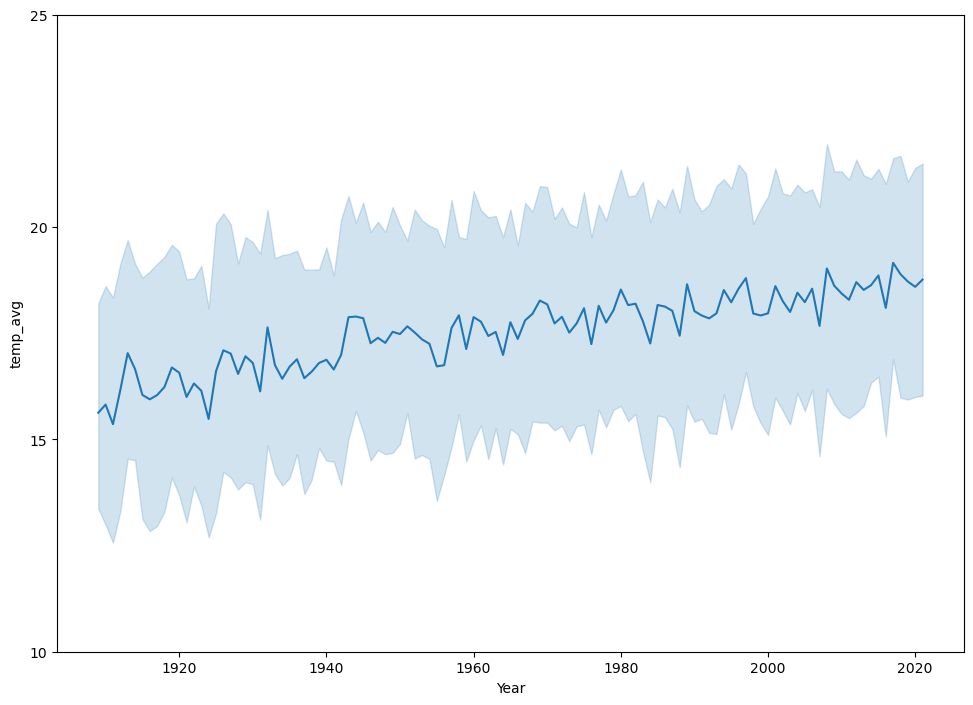

In [23]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(x='Year' ,y='temp_avg', data=df, markers=True, dashes=False)


plt.yticks([10, 15, 20, 25])

In [24]:
df_wide = df.pivot("Year", "Month", "temp_avg")
df_wide.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
1909,23.175806,21.280357,19.170968,17.501667,11.179032,8.413333,9.593548,12.490323,13.583333,14.629032,16.561667,19.958065
1910,23.275806,20.978571,18.188710,15.695000,11.938710,10.771667,8.554839,10.877419,12.420000,15.351613,19.150000,22.658065
1911,23.574194,21.825000,19.398387,15.866667,12.933871,7.946667,9.295161,9.483871,10.446667,14.248387,18.508333,20.783871
1912,23.516129,22.798276,21.127419,15.918333,12.483871,10.231667,8.756452,9.362903,12.755000,16.498387,17.790000,22.753226
1913,22.883871,25.601786,19.230645,18.436667,14.887097,10.116667,12.606452,11.633871,13.195000,15.585484,19.205000,21.014516


In [25]:
# VEMOS LA TENDENCIA DE CADA MES A LO LARGO DE LOS AÑOS--------------
#for i in df_wide.columns:
#    plt.figure()
#    plt.tight_layout()
#    sns.set(rc={"figure.figsize":(8, 5)})
#    plt.gca().set(xlabel= i,ylabel='Frequency')
#    sns.lineplot(x= 'Year', y= i ,data=df_wide)
#    plt.yticks([15, 20, 25 , 30])

In [26]:
#Se crean las dummies de los meses para estudiar luego estacionalidad

dummies_mes=pd.get_dummies(df.index.month,drop_first=True)
dummies=pd.DataFrame(dummies_mes)

In [27]:
#Se renombran las dummies y se usa el index del dataframe

dummies=dummies.rename(columns={2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})
dummies.index=df.index
dummies.head(3)

,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
Fecha,,,,,,,,,,,
1909-01,0,0,0,0,0,0,0,0,0,0,0
1909-02,1,0,0,0,0,0,0,0,0,0,0
1909-03,0,1,0,0,0,0,0,0,0,0,0


In [28]:
#Se agregan las dummies al df

df=pd.merge(df, dummies, left_index=True, right_index=True)
df.head(3)

,temp_min,temp_max,temp_avg,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
Fecha,,,,,,,,,,,,,,,,
1909-01,17.422581,28.929032,23.175806,1909,1,0,0,0,0,0,0,0,0,0,0,0
1909-02,16.000000,26.560714,21.280357,1909,2,1,0,0,0,0,0,0,0,0,0,0
1909-03,13.012903,25.329032,19.170968,1909,3,0,1,0,0,0,0,0,0,0,0,0


In [29]:
#Se agregan columnas logaritmicas de la temperatura para hacer pruebas
#df['temp_min_log']=np.log(df['temp_min'])
#df['temp_max_log']=np.log(df['temp_max'])
#df['temp_avg_log']=np.log(df['temp_avg'])

In [30]:
#Se agrega el timeindex

df["timeIndex"] = pd.Series(np.arange(len(df['temp_min'])), index=df.index)

In [31]:
df.head(3)

,temp_min,temp_max,temp_avg,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,timeIndex
Fecha,,,,,,,,,,,,,,,,,
1909-01,17.422581,28.929032,23.175806,1909,1,0,0,0,0,0,0,0,0,0,0,0,0
1909-02,16.000000,26.560714,21.280357,1909,2,1,0,0,0,0,0,0,0,0,0,0,1
1909-03,13.012903,25.329032,19.170968,1909,3,0,1,0,0,0,0,0,0,0,0,0,2


In [32]:
#Trabajamos primero con la temperatura minima

In [33]:
# Dividimos en train y test
df_train, df_test = train_test_split(df, test_size=48, random_state=42, shuffle=False)

In [34]:
#Modelamos estacionalidad

model_est = smf.ols('temp_min ~ timeIndex + feb +	mar +	apr +	may +	jun +	jul +	aug + sep +	oct +	nov +	dec', data = df_train,hasconst=True).fit()

In [35]:
df_train['predict_est'] = model_est.predict(df_train[['timeIndex','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']])


df_test['predict_est'] = model_est.predict(df_test[['timeIndex','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']])

In [36]:
#df_train['back_predict_log_est'] = np.exp(df_train['predict_log_est'])
#df_test['back_predict_log_est'] = np.exp(df_test['predict_log_est'])

In [37]:
display(df_train.head(2))
display(df_test.head(2))

,temp_min,temp_max,temp_avg,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,timeIndex,predict_est
Fecha,,,,,,,,,,,,,,,,,,
1909-01,17.422581,28.929032,23.175806,1909,1,0,0,0,0,0,0,0,0,0,0,0,0,17.255880
1909-02,16.000000,26.560714,21.280357,1909,2,1,0,0,0,0,0,0,0,0,0,0,1,16.621379


,temp_min,temp_max,temp_avg,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,timeIndex,predict_est
Fecha,,,,,,,,,,,,,,,,,,
2018-01,20.812903,31.406452,26.109677,2018,1,0,0,0,0,0,0,0,0,0,0,0,1308,20.738187
2018-02,20.264286,30.367857,25.316071,2018,2,1,0,0,0,0,0,0,0,0,0,0,1309,20.103686


<AxesSubplot:xlabel='Fecha'>

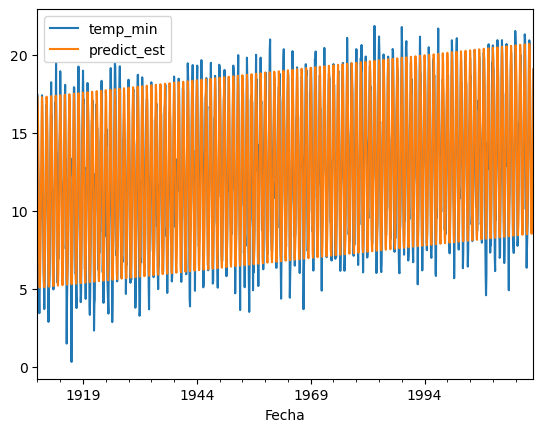

In [38]:
#Ploteamos temp_min contra prediccion de ols
df_train.plot(kind = "line", y = ['temp_min', 'predict_est'])

<AxesSubplot:xlabel='Fecha'>

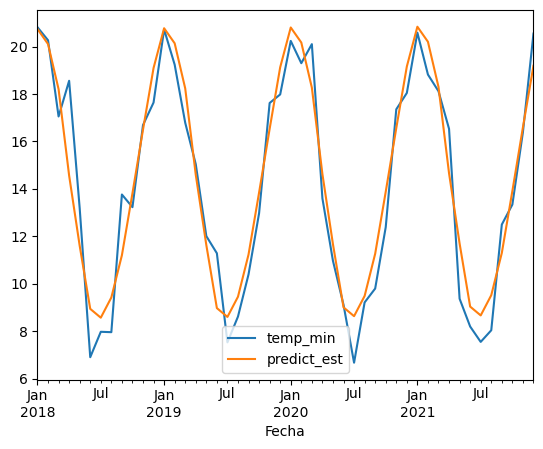

In [39]:
df_test.plot(kind = "line", y = ['temp_min', 'predict_est'])

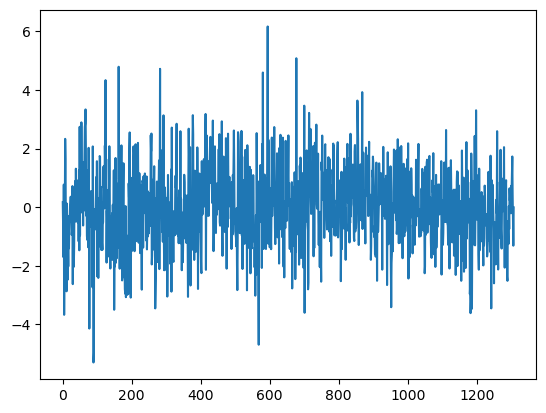

In [40]:
#Calculamos los residuos para hacer Dickey-Fuller y ver si se puede trabajar con los ciclos

res_model = df_train['temp_min'] - df_train['predict_est']

plt.plot(df_train.timeIndex, res_model, '-');

In [41]:
df.iloc[78]

temp_min        4.548387
temp_max       15.132258
temp_avg        9.840323
Year         1915.000000
Month           7.000000
feb             0.000000
mar             0.000000
apr             0.000000
may             0.000000
jun             0.000000
jul             1.000000
aug             0.000000
sep             0.000000
oct             0.000000
nov             0.000000
dec             0.000000
timeIndex      78.000000
Name: 1915-07, dtype: float64

In [42]:
result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -17.862133
p-value: 0.000000
Valor crítico 1%: -3.44
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


In [43]:
#Se puede rechazar la hipotesis nula, y trabajar con los ciclos

In [44]:
#Calculamos AFC para 30 lags

lag_acf = acf(res_model, nlags = 20)
lag_acf


array([ 1.        ,  0.1817886 ,  0.08126227,  0.07037871,  0.01783161,
        0.02060134, -0.01010749,  0.03287855,  0.00227995,  0.05624027,
        0.05864025,  0.02894574,  0.0539158 ,  0.06879158,  0.03405507,
        0.00713931,  0.04102971,  0.01956127,  0.02176209, -0.00148574,
        0.00815299])

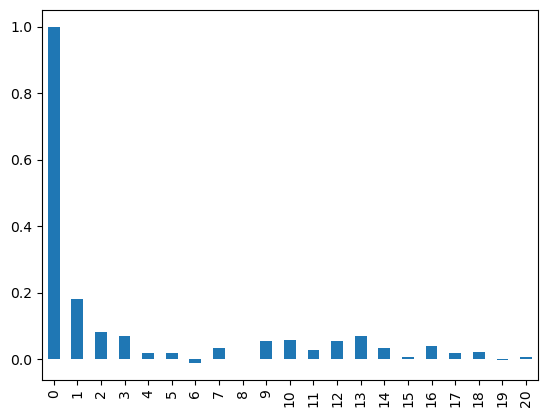

In [45]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

In [46]:
#Calculamos PACF para 30 lags
lag_pacf = pacf(res_model, nlags=20, method='ols')

<AxesSubplot:>

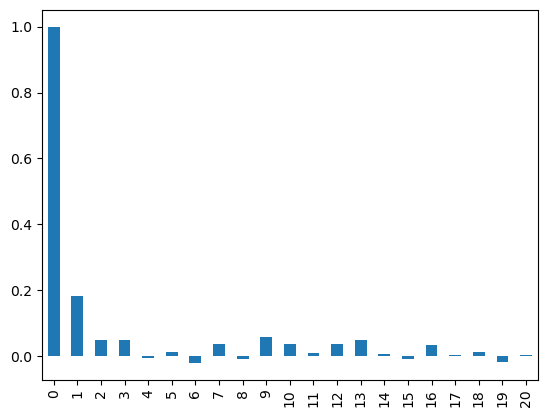

In [47]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar")

In [48]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

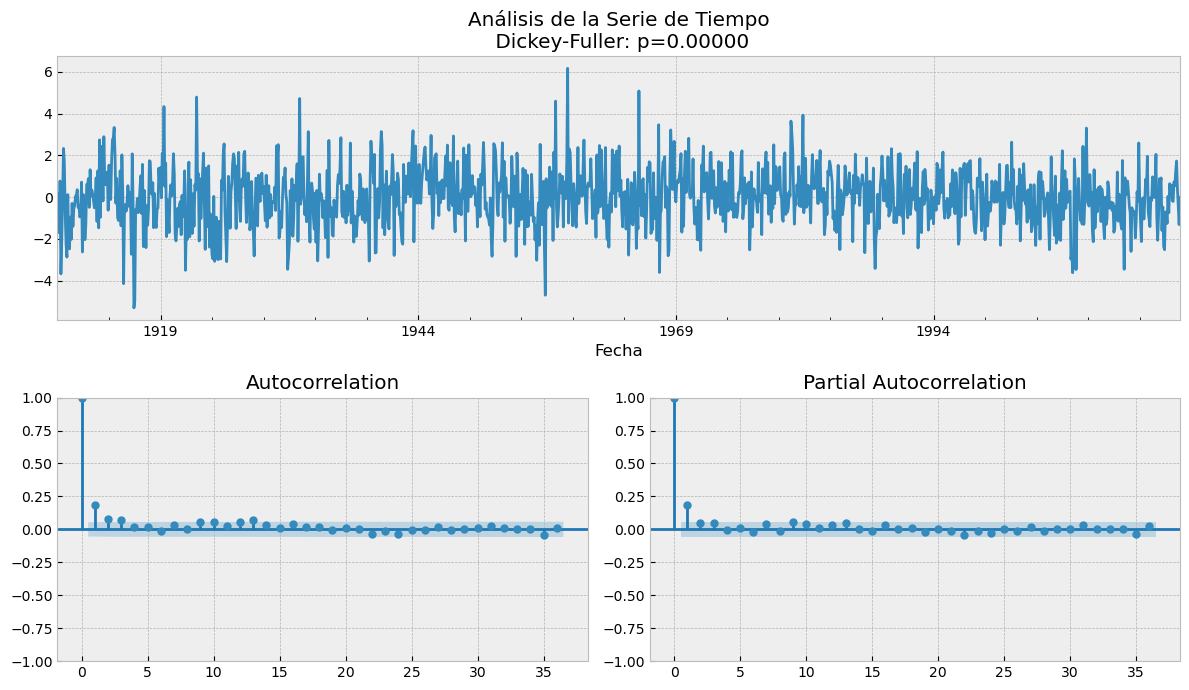

In [49]:
# Corremos la función con nuestra serie res_log:

tsplot(res_model, lags=36)

In [50]:
#Tomamos p=4 y q=2 para Arima

model_ARIMA = sm.tsa.arima.ARIMA(res_model, order=(4,0,2))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

Fecha
1909-01   -0.031615
1909-02    0.004482
1909-03   -0.123690
1909-04   -0.333592
1909-05    0.003279
Freq: M, dtype: float64

In [51]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1308
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -2232.154
Date:                Wed, 22 Mar 2023   AIC                           4480.309
Time:                        21:17:59   BIC                           4521.719
Sample:                    01-31-1909   HQIC                          4495.841
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0316      0.095     -0.333      0.739      -0.218       0.155
ar.L1          0.3527      0.181      1.944      0.052      -0.003       0.708
ar.L2          0.7943      0.207      3.842      0.0

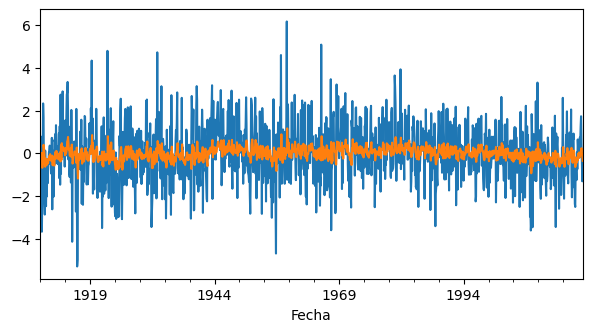

In [52]:
plt.figure(figsize=(7,3.5))
res_model.plot()
results_ARIMA.fittedvalues.plot();

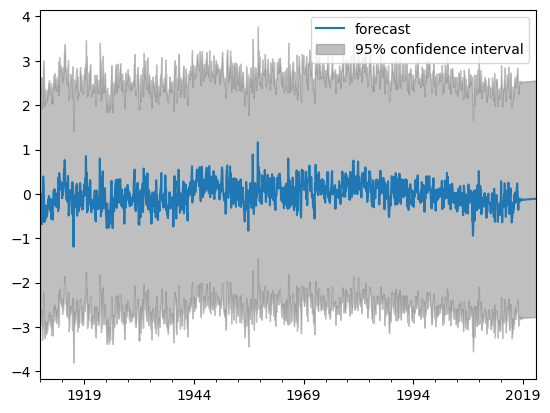

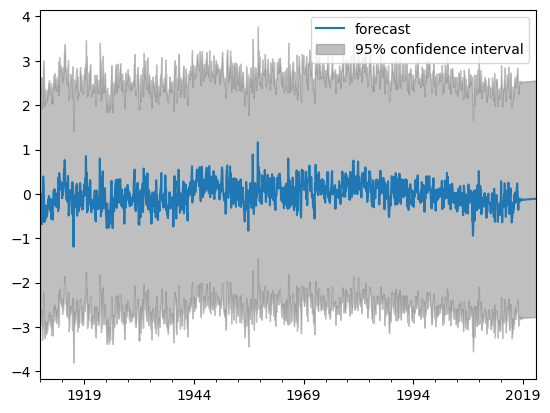

In [53]:
plot_predict(results_ARIMA, end=len(df['temp_min']))

In [54]:
#Analizamos residuos

res_ARIMA =  results_ARIMA.fittedvalues - res_model

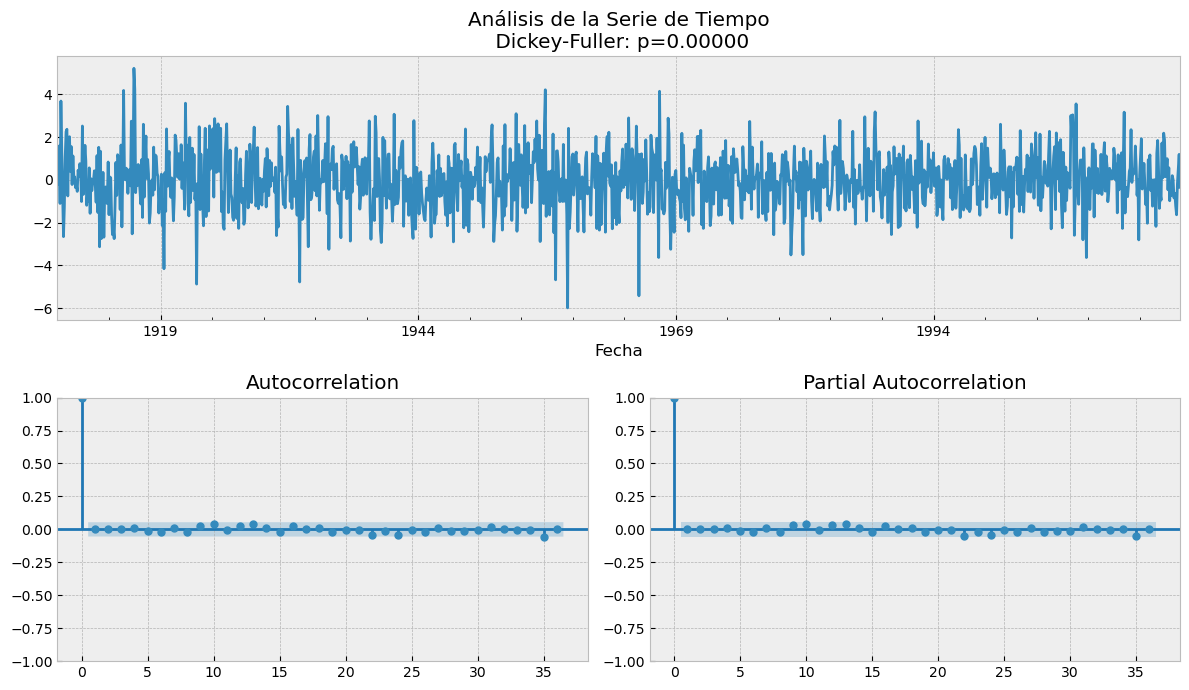

In [55]:
tsplot(res_ARIMA, lags=36)

In [56]:
#Hacemos predicciones out of sample
predictions_ARIMA = results_ARIMA.forecast(len(df_test['temp_min']), alpha=0.05)

In [57]:
#Se incorpora el comportamiento ciclico a nuestro modelo

df_train['model_ARIMA'] = df_train['predict_est'] + results_ARIMA.fittedvalues

df_test['model_ARIMA'] = df_test['predict_est'] + predictions_ARIMA

In [58]:
with open('df_test.pkl', 'wb') as f_dftest:
    pickle.dump(df_test, f_dftest)

In [59]:
#  levantamos el df_test
with open('./df_test.pkl', 'rb') as f_dftest:
        dataset_test = pickle.load(f_dftest)

<AxesSubplot:xlabel='Fecha'>

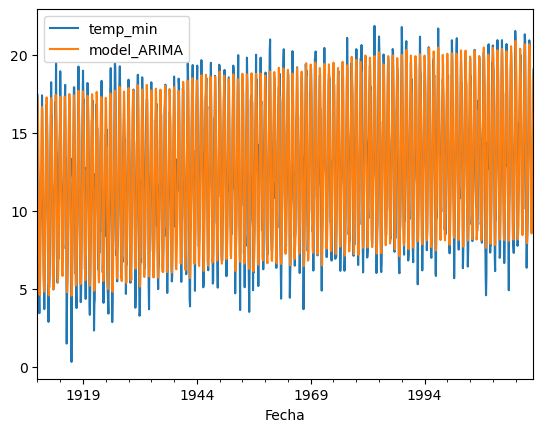

In [60]:
df_train.plot(kind = "line", y = ['temp_min', 'model_ARIMA'])

<AxesSubplot:xlabel='Fecha'>

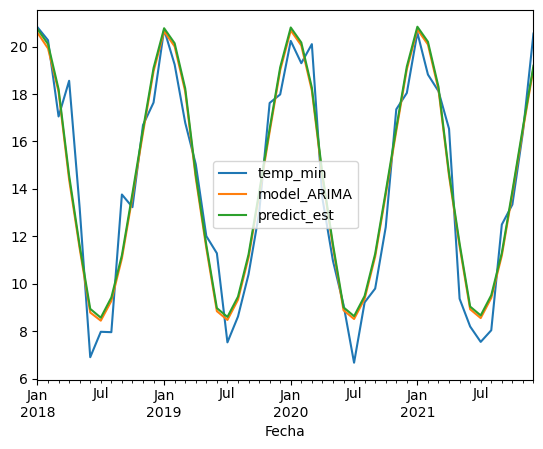

In [61]:
df_test.plot(kind = "line", y = ['temp_min', 'model_ARIMA','predict_est'])

In [62]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [63]:
RMSE(df_test['model_ARIMA'], df_test['temp_min'])

1.3134244224270948

In [64]:
RMSE(df_test['predict_est'], df_test['temp_min'])

1.329067217883456

In [65]:
df

,temp_min,temp_max,temp_avg,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,timeIndex
Fecha,,,,,,,,,,,,,,,,,
1909-01,17.422581,28.929032,23.175806,1909,1,0,0,0,0,0,0,0,0,0,0,0,0
1909-02,16.000000,26.560714,21.280357,1909,2,1,0,0,0,0,0,0,0,0,0,0,1
1909-03,13.012903,25.329032,19.170968,1909,3,0,1,0,0,0,0,0,0,0,0,0,2
1909-04,11.850000,23.153333,17.501667,1909,4,0,0,1,0,0,0,0,0,0,0,0,3
1909-05,4.441935,17.916129,11.179032,1909,5,0,0,0,1,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,8.041935,18.400000,13.220968,2021,8,0,0,0,0,0,0,1,0,0,0,0,1351
2021-09,12.496667,19.450000,15.973333,2021,9,0,0,0,0,0,0,0,1,0,0,0,1352
2021-10,13.338710,24.280645,18.809677,2021,10,0,0,0,0,0,0,0,0,1,0,0,1353


In [66]:
inicio = df.index[9]
inicio

Period('1909-10', 'M')

In [67]:
"""from datetime import datetime

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

inicio = df.infer_objects
final = input('Teclear fecha final (dd/mm/yyyy): ')

F_inicio = datetime.strptime(inicio, "%d/%m/%Y")
F_final = datetime.strptime(final, "%d/%m/%Y")

print(diff_month(F_final, F_inicio))
"""

'from datetime import datetime\n\ndef diff_month(d1, d2):\n    return (d1.year - d2.year) * 12 + d1.month - d2.month\n\ninicio = df.infer_objects\nfinal = input(\'Teclear fecha final (dd/mm/yyyy): \')\n\nF_inicio = datetime.strptime(inicio, "%d/%m/%Y")\nF_final = datetime.strptime(final, "%d/%m/%Y")\n\nprint(diff_month(F_final, F_inicio))\n'

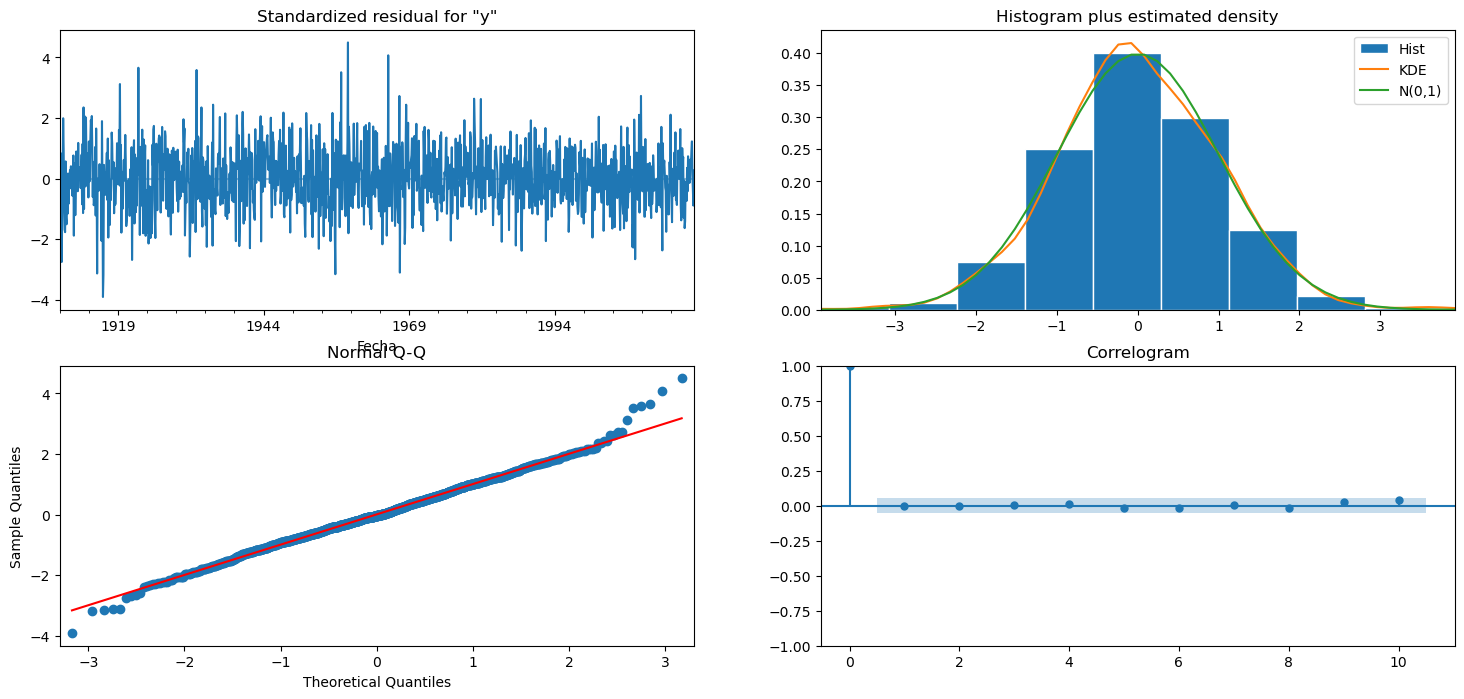

In [68]:
results_ARIMA.plot_diagnostics(figsize=(18, 8))
plt.show()

In [69]:
alpha = .05

predictions = model_est.get_prediction(df).summary_frame(alpha)
predictions.mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of            mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0     17.255880  0.146355      16.968761      17.542999     14.554544   
1     16.621379  0.146355      16.334260      16.908498     13.920043   
2     14.720159  0.146355      14.433040      15.007278     12.018824   
3     11.078885  0.146355      10.791766      11.366005      8.377550   
4      8.119830  0.146355       7.832710       8.406949      5.418494   
...         ...       ...            ...            ...           ...   
1351   9.520003  0.148554       9.228569       9.811436      6.818205   
1352  11.299057  0.148554      11.007623      11.590490      8.597259   
1353  13.909651  0.148554      13.618218      14.201085     11.207854   
1354  16.593797  0.148554      16.302363      16.885230     13.891999   
1355  19.190360  0.148554      18.898926      19.481793     16.488562   

      obs_ci_upper  
0        19.957215  
1        19.322714

In [70]:
df_pred = pd.DataFrame()
df_pred.set_index = df.index
df_pred['Year'] = df.index.year
df_pred['Month'] = df.index.month
df_pred

,Year,Month
0,1909,1
1,1909,2
2,1909,3
3,1909,4
4,1909,5
...,...,...
1351,2021,8
1352,2021,9
1353,2021,10
1354,2021,11


In [71]:
fecha_pred = '2025/10'

In [72]:
fecha = datetime.strptime(fecha_pred, '%Y/%m')


In [73]:
años = []
año = 2022
for i in range(0,(fecha.year-2022)+1):
    años.append(año)
    año += 1
años

[2022, 2023, 2024, 2025]

In [74]:
mes = 1
for año in años:
    if(año != años[-1]):
        i = 12
    elif(año == años[-1]):
        i= fecha.month
    for i in range (0,i):
        df_pred.loc[df_pred.shape[0]] = [año,i+1]

In [75]:
df_pred

,Year,Month
0,1909,1
1,1909,2
2,1909,3
3,1909,4
4,1909,5
...,...,...
1397,2025,6
1398,2025,7
1399,2025,8
1400,2025,9


In [76]:
dummies_mes_pred = pd.get_dummies(df_pred["Month"],drop_first=True)
dummies_pred=pd.DataFrame(dummies_mes_pred)
dummies_pred



,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1397,0,0,0,0,1,0,0,0,0,0,0
1398,0,0,0,0,0,1,0,0,0,0,0
1399,0,0,0,0,0,0,1,0,0,0,0
1400,0,0,0,0,0,0,0,1,0,0,0


In [77]:
dummies_pred=dummies_pred.rename(columns={2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})
dummies_pred


,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1397,0,0,0,0,1,0,0,0,0,0,0
1398,0,0,0,0,0,1,0,0,0,0,0
1399,0,0,0,0,0,0,1,0,0,0,0
1400,0,0,0,0,0,0,0,1,0,0,0


In [78]:
dummies_pred.index=df_pred.index
df_pred=pd.merge(df_pred, dummies_pred, left_index=True, right_index=True)
#df_pred.to_excel('df_pred.xlsx')

In [79]:
df_pred['timeIndex']=df_pred.index
df_pred

,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,timeIndex
0,1909,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1909,2,1,0,0,0,0,0,0,0,0,0,0,1
2,1909,3,0,1,0,0,0,0,0,0,0,0,0,2
3,1909,4,0,0,1,0,0,0,0,0,0,0,0,3
4,1909,5,0,0,0,1,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,2025,6,0,0,0,0,1,0,0,0,0,0,0,1397
1398,2025,7,0,0,0,0,0,1,0,0,0,0,0,1398
1399,2025,8,0,0,0,0,0,0,1,0,0,0,0,1399
1400,2025,9,0,0,0,0,0,0,0,1,0,0,0,1400


In [80]:
df_pred['Fecha'] = str(df_pred['Year']) + '-' + str(df_pred['Month'])

for i in range (0, df_pred.shape[0]):
    df_pred['Fecha'][i] = datetime.strptime(str(df_pred['Year'][i]) +'-'+ str(df_pred['Month'][i]), "%Y-%m")   
df_pred  


,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,timeIndex,Fecha
0,1909,1,0,0,0,0,0,0,0,0,0,0,0,0,1909-01-01 00:00:00
1,1909,2,1,0,0,0,0,0,0,0,0,0,0,1,1909-02-01 00:00:00
2,1909,3,0,1,0,0,0,0,0,0,0,0,0,2,1909-03-01 00:00:00
3,1909,4,0,0,1,0,0,0,0,0,0,0,0,3,1909-04-01 00:00:00
4,1909,5,0,0,0,1,0,0,0,0,0,0,0,4,1909-05-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,2025,6,0,0,0,0,1,0,0,0,0,0,0,1397,2025-06-01 00:00:00
1398,2025,7,0,0,0,0,0,1,0,0,0,0,0,1398,2025-07-01 00:00:00
1399,2025,8,0,0,0,0,0,0,1,0,0,0,0,1399,2025-08-01 00:00:00
1400,2025,9,0,0,0,0,0,0,0,1,0,0,0,1400,2025-09-01 00:00:00


In [81]:
pred_reg = model_est.predict(df_pred[['timeIndex','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']])
pred_reg


0       17.255880
1       16.621379
2       14.720159
3       11.078885
4        8.119830
          ...    
1397     9.167673
1398     8.795322
1399     9.647794
1400    11.426848
1401    14.037442
Length: 1402, dtype: float64

In [82]:
pred_uc = results_ARIMA.get_prediction(start='1909-01',end=fecha)
pred_uc = pred_uc.predicted_mean
#pred_uc.columns = ['predicted1','predicted2', 'predicted_n']
#pred_uc_ci = pred_uc.conf_int(alpha=0.05)
pred_uc

1909-01   -0.031615
1909-02    0.004482
1909-03   -0.123690
1909-04   -0.333592
1909-05    0.003279
             ...   
2025-06   -0.088618
2025-07   -0.088195
2025-08   -0.087776
2025-09   -0.087359
2025-10   -0.086946
Freq: M, Name: predicted_mean, Length: 1402, dtype: float64

In [83]:
predicciones = [ pred_reg[x] + pred_uc[x] for x in range(0,len(pred_reg))]
predicciones

[17.22426486251246,
 16.625860546119494,
 14.596468866928078,
 10.7452938693303,
 8.12310821390237,
 4.778051958479027,
 4.617621816784501,
 5.617462461054914,
 8.11375232860242,
 10.569019854099244,
 13.010178534358298,
 15.100260544653196,
 16.654929875689472,
 16.400503155200543,
 14.28469536240853,
 10.551611880789576,
 7.679965650881493,
 4.972464581027661,
 4.832925885114517,
 5.520786116319042,
 7.49133191203819,
 10.03946828605776,
 12.927412621085558,
 15.458287176499775,
 17.273437562573577,
 16.435734821738276,
 14.58815305050189,
 10.770521034666475,
 7.887471796012745,
 5.411238721255607,
 4.590689642900021,
 5.795964502099762,
 7.3585656578580645,
 9.94949961342102,
 12.498106285922876,
 15.56342622622053,
 17.22762117902391,
 16.786096251475513,
 14.561456670354588,
 11.281914614569194,
 8.044316315594555,
 5.572844426593345,
 4.990314674674227,
 5.943254027744311,
 7.523471256568152,
 10.300353378331986,
 13.076126973642149,
 15.444947651982847,
 17.428645525022052,
 16

In [84]:
prediccion = pd.DataFrame()
prediccion['Fecha'] = df_pred['Fecha']

prediccion['Temp'] = predicciones
prediccion

,Fecha,Temp
0,1909-01-01 00:00:00,17.224265
1,1909-02-01 00:00:00,16.625861
2,1909-03-01 00:00:00,14.596469
3,1909-04-01 00:00:00,10.745294
4,1909-05-01 00:00:00,8.123108
...,...,...
1397,2025-06-01 00:00:00,9.079055
1398,2025-07-01 00:00:00,8.707127
1399,2025-08-01 00:00:00,9.560018
1400,2025-09-01 00:00:00,11.339488


In [85]:
def prediccion_fecha(fecha_pred):
    
    df_pred = pd.DataFrame()
    df_pred.set_index = df.index
    df_pred['Year'] = df.index.year
    df_pred['Month'] = df.index.month
    df_pred

    fecha = datetime.strptime(fecha_pred, '%Y/%m')

    años = []
    año = 2022
    for i in range(0,(fecha.year-año)+1):
        años.append(año)
        año += 1
    
    for año in años:
        if(año != años[-1]):
            i = 12
        elif(año == años[-1]):
            i= fecha.month
        for i in range (0,i):
            df_pred.loc[df_pred.shape[0]] = [año,i+1]

    dummies_mes_pred = pd.get_dummies(df_pred["Month"], drop_first=True)
    dummies_pred=pd.DataFrame(dummies_mes_pred)
    dummies_pred=dummies_pred.rename(columns={2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})

    dummies_pred.index = df_pred.index
    df_pred=pd.merge(df_pred, dummies_pred, left_index=True, right_index=True)

    df_pred['timeIndex']=df_pred.index
    df_pred['Fecha'] = str(df_pred['Year']) + '-' + str(df_pred['Month'])

    for i in range (0, df_pred.shape[0]):
        df_pred['Fecha'][i] = datetime.strptime(str(df_pred['Year'][i]) +'-'+ str(df_pred['Month'][i]), "%Y-%m")   

    pred_reg = model_est.predict(df_pred[['timeIndex','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']])
    pred_arima = results_ARIMA.get_prediction(start='1909-01',end=fecha)
    pred_arima = pred_arima.predicted_mean


    predicciones = [ pred_reg[x] + pred_arima[x] for x in range(0,len(pred_reg))] 
    prediccion = pd.DataFrame()
    prediccion['Fecha'] = df_pred['Fecha']

    prediccion['Temp'] = predicciones
    return prediccion

In [86]:
prediccion_fecha('2025/2')

,Fecha,Temp
0,1909-01-01 00:00:00,17.224265
1,1909-02-01 00:00:00,16.625861
2,1909-03-01 00:00:00,14.596469
3,1909-04-01 00:00:00,10.745294
4,1909-05-01 00:00:00,8.123108
...,...,...
1389,2024-10-01 00:00:00,13.913379
1390,2024-11-01 00:00:00,16.597973
1391,2024-12-01 00:00:00,19.194982
1392,2025-01-01 00:00:00,20.871042


In [105]:
#Se crea un dataframe para temperatura minima y maxima, agrupado por año y mes con la media de cada mes

df_temp_min_mensual=pd.DataFrame(df_temp_min.groupby(pd.PeriodIndex(df_temp_min.index, freq="M"))['temp_min'].mean())
df_temp_max_mensual=pd.DataFrame(df_temp_max.groupby(pd.PeriodIndex(df_temp_max.index, freq="M"))['temp_max'].mean())

In [106]:
df=pd.concat([df_temp_min_mensual,df_temp_max_mensual],axis=1)

In [107]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df.head()

,temp_min,temp_max,Year,Month
Fecha,,,,
1909-01,17.422581,28.929032,1909,1
1909-02,16.000000,26.560714,1909,2
1909-03,13.012903,25.329032,1909,3
1909-04,11.850000,23.153333,1909,4
1909-05,4.441935,17.916129,1909,5


In [108]:
#Descomponemos la serie de tiempo

df["date"] = df["Year"].astype('string') + '/' + df["Month"].astype('string') + '/1'

df["date"] = pd.to_datetime(df["date"])
df.head(3)

,temp_min,temp_max,Year,Month,date
Fecha,,,,,
1909-01,17.422581,28.929032,1909,1,1909-01-01
1909-02,16.000000,26.560714,1909,2,1909-02-01
1909-03,13.012903,25.329032,1909,3,1909-03-01


In [109]:
#Se agrega el timeindex

df["timeIndex"] = pd.Series(np.arange(len(df)), index=df.index)

In [110]:
# Dividimos en train y test
df_train, df_test = train_test_split(df, test_size=48, random_state=42, shuffle=False)

In [111]:
#Realiza la imputacion promediando las temperaturas de los mismos meses a lo largo de los anios 
df_train = df_train.groupby("Month").transform(lambda x: x.fillna(x.mean()))

In [112]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1308 entries, 1909-01 to 2017-12
Freq: M
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   temp_min   1308 non-null   float64       
 1   temp_max   1308 non-null   float64       
 2   Year       1308 non-null   int64         
 3   date       1308 non-null   datetime64[ns]
 4   timeIndex  1308 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 56.2 KB


In [113]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from statsmodels.formula.api import glm as glm_sm

In [114]:
class Create_month_dummies(BaseEstimator, TransformerMixin):
    #crea las dummies de mes para la estacionalidad
    def __init__(self):
        self.months={2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'}
    
    def fit(self,X, y=None):
        return self
    
    def transform(self, X, y=None):
        dummies_mes=pd.get_dummies(X.index.month,drop_first=True)
        dummies=pd.DataFrame(dummies_mes)
        dummies=dummies.rename(columns =self.months)
        dummies.index=X.index
        X=pd.merge(X, dummies, left_index=True, right_index=True)
        
        return X

In [115]:
class FeatureSelection(BaseEstimator, TransformerMixin):

    def __init__(self,selected_features):
        self.selected_features=selected_features

    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.selected_features]

In [116]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)


In [117]:
Feature_1 = ['timeIndex' , 'feb' , 'mar' ,'apr','may' ,'jun' ,'jul' ,'aug' , 'sep' ,	'oct' ,	'nov' ,	'dec']

In [118]:
pasos = [('Create_dummies',Create_month_dummies()),('Feature_selection',FeatureSelection(Feature_1)),('Linear_model',SMWrapper(sm.OLS))]

pipe=Pipeline(pasos)

In [119]:
pipe.fit(df_train,df_train['temp_min'])

Pipeline(steps=[('Create_dummies', Create_month_dummies()),
                ('Feature_selection',
                 FeatureSelection(selected_features=['timeIndex', 'feb', 'mar',
                                                     'apr', 'may', 'jun', 'jul',
                                                     'aug', 'sep', 'oct', 'nov',
                                                     'dec'])),
                ('Linear_model',
                 SMWrapper(model_class=<class 'statsmodels.regression.linear_model.OLS'>))])

In [120]:
pipe.predict(df_train)

Fecha
1909-01    17.255880
1909-02    16.621379
1909-03    14.720159
1909-04    11.078885
1909-05     8.119830
             ...    
2017-08     9.392211
2017-09    11.171265
2017-10    13.781860
2017-11    16.466005
2017-12    19.062569
Freq: M, Length: 1308, dtype: float64

In [121]:
pipe.predict(df_test)

Fecha
2018-01    20.738187
2018-02    20.103686
2018-03    18.202466
2018-04    14.561193
2018-05    11.602137
2018-06     8.944039
2018-07     8.571688
2018-08     9.424159
2018-09    11.203213
2018-10    13.813808
2018-11    16.497953
2018-12    19.094516
2019-01    20.770135
2019-02    20.135634
2019-03    18.234414
2019-04    14.593141
2019-05    11.634085
2019-06     8.975987
2019-07     8.603636
2019-08     9.456107
2019-09    11.235161
2019-10    13.845756
2019-11    16.529901
2019-12    19.126464
2020-01    20.802083
2020-02    20.167582
2020-03    18.266362
2020-04    14.625088
2020-05    11.666032
2020-06     9.007934
2020-07     8.635584
2020-08     9.488055
2020-09    11.267109
2020-10    13.877704
2020-11    16.561849
2020-12    19.158412
2021-01    20.834030
2021-02    20.199529
2021-03    18.298310
2021-04    14.657036
2021-05    11.697980
2021-06     9.039882
2021-07     8.667531
2021-08     9.520003
2021-09    11.299057
2021-10    13.909651
2021-11    16.593797
2021-12

In [122]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [123]:
RMSE(pipe.predict(df_train),df_train['temp_min'])

1.3623486321575955

In [124]:
RMSE(pipe.predict(df_test),df_test['temp_min'])

1.329067217883456

In [125]:
df_test_pred = df_test
df_test_pred['model_lineal'] = pipe.predict(df_test)

<AxesSubplot:xlabel='Fecha'>

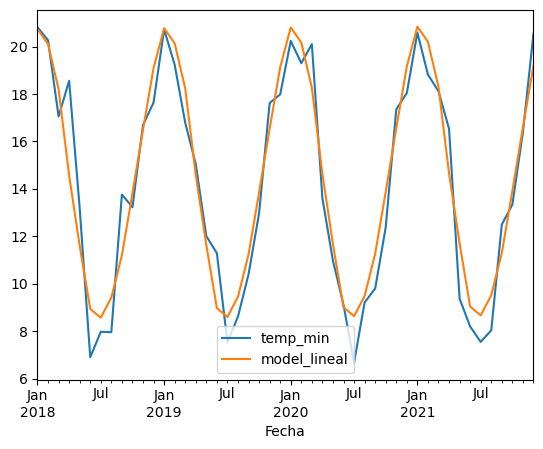

In [126]:
df_test_pred.plot(kind = "line", y = ['temp_min','model_lineal'])



In [127]:
pipe.fit(df_train,df_train['temp_max'])

Pipeline(steps=[('Create_dummies', Create_month_dummies()),
                ('Feature_selection',
                 FeatureSelection(selected_features=['timeIndex', 'feb', 'mar',
                                                     'apr', 'may', 'jun', 'jul',
                                                     'aug', 'sep', 'oct', 'nov',
                                                     'dec'])),
                ('Linear_model',
                 SMWrapper(model_class=<class 'statsmodels.regression.linear_model.OLS'>))])

In [128]:
pipe.predict(df_train)

Fecha
1909-01    28.990113
1909-02    27.811122
1909-03    25.511835
1909-04    21.700432
1909-05    18.041045
             ...    
2017-08    17.746289
2017-09    19.730034
2017-10    22.617375
2017-11    26.038750
2017-12    29.116428
Freq: M, Length: 1308, dtype: float64

In [129]:
pipe.predict(df_test)

Fecha
2018-01    30.701170
2018-02    29.522179
2018-03    27.222892
2018-04    23.411489
2018-05    19.752102
2018-06    16.420289
2018-07    16.007852
2018-08    17.761987
2018-09    19.745732
2018-10    22.633073
2018-11    26.054448
2018-12    29.132126
2019-01    30.716867
2019-02    29.537877
2019-03    27.238590
2019-04    23.427187
2019-05    19.767800
2019-06    16.435987
2019-07    16.023550
2019-08    17.777684
2019-09    19.761430
2019-10    22.648770
2019-11    26.070146
2019-12    29.147823
2020-01    30.732565
2020-02    29.553574
2020-03    27.254288
2020-04    23.442884
2020-05    19.783497
2020-06    16.451684
2020-07    16.039247
2020-08    17.793382
2020-09    19.777128
2020-10    22.664468
2020-11    26.085843
2020-12    29.163521
2021-01    30.748263
2021-02    29.569272
2021-03    27.269985
2021-04    23.458582
2021-05    19.799195
2021-06    16.467382
2021-07    16.054945
2021-08    17.809080
2021-09    19.792826
2021-10    22.680166
2021-11    26.101541
2021-12

In [130]:
RMSE(pipe.predict(df_train),df_train['temp_max'])

1.2824052723514958

In [131]:
RMSE(pipe.predict(df_test),df_test['temp_max'])

1.0007318592377519

In [132]:
df_test_pred = df_test
df_test_pred['model_lineal'] = pipe.predict(df_test)

<AxesSubplot:xlabel='Fecha'>

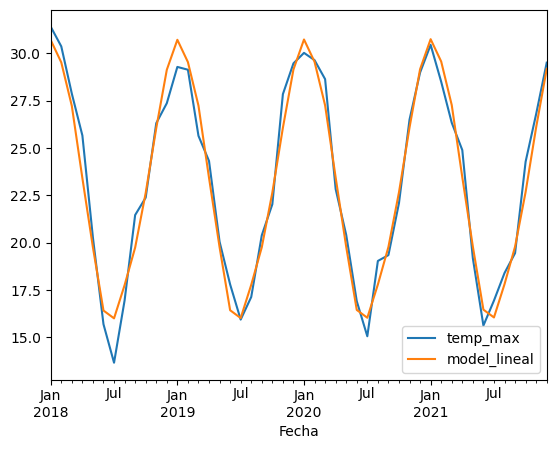

In [133]:
df_test_pred.plot(kind = "line", y = ['temp_max','model_lineal'])